# Exploring Spanish 2nd Hand Cars market
Used cars are a quite big business in Spain, keeping in mind that **the ratio between new cars sells and used cars sells is more than 2:3** you can imagine the magnitude of it. This project's aim is to find some key points in the motor world, attempting to clearify 'what' we have now if we want to buy a used car.

The final idea is to be able to find what makes the car's price, **identify how each element varies the price and build a robust prediction system** in order to identify good deals or make an estimation if we are thinking about selling a car.

This project is end-to-end, going **from data-mining** scraping some used car selling webs **to model deployment** with a web frontend. Here you can find the second step after data-scraping; **let's do some data analysis!**

In [52]:
# Import necessary packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set_style("whitegrid")
%matplotlib inline

## Data preprocessing
### Merging data from different sources

For this project 6 different websites have been scraped, as the first attempt was to scrape them separately we need to join all the files now.

In the data we will be using we can find these colums:

- title: Ad title, normally containing the **brand and the model** of the car
- price: Car price in euros
- provence: Spanish region where the car is
- fuel: What the car uses to stay on
- kilometers: Number of driven kms
- change: Manual or automatic
- power: Number of cvs 

In [53]:
DATA_COLUMNS = ['title', 'price', 'provence', 'year', 'fuel', 'kilometers', 'change', 'power']

df = pd.read_csv('./data/motor.csv', encoding = "ISO-8859-1")
df1 = pd.read_csv('./data/second_hand_cars.csv')
df2 = pd.read_csv('./data/second_hand_cars_2.csv')
df3 = pd.read_csv('./data/second_hand_cars_3.csv')
df4 = pd.read_csv('./data/second_hand_cars_4.csv')
df5 = pd.read_csv('./data/second_hand_cars_5.csv')
df6 = pd.read_json('./data/web1.json')
df7 = pd.read_json('./data/web1_2try.json')
df8 = pd.read_json('./data/web1_3try.json')

df1.columns = DATA_COLUMNS
df2.columns = DATA_COLUMNS
df3.columns = DATA_COLUMNS
df4.columns = DATA_COLUMNS
df5.columns = DATA_COLUMNS

df_list = [df, df1, df2, df3, df4, df5, df6, df7, df8]

# Concat all dataframes in one
df = pd.concat(df_list, sort=True)

# Too many blanks
df = df.drop(columns='change')

df.head()

,fuel,kilometers,power,price,provence,title,year
0,Diesel,243.000 Km,90 CV,4.500 ,Torrijos (Toledo)\r\nHace 34 minutos,Ford Transit Connect Combi 5 90 cv,2007
1,Gasolina,213.800 Km,147 CV,2.995 ,Torrijos (Toledo)\r\nHace 34 minutos,Honda CR-V AUTOMATICO 4X4,2000
2,Diesel,192.800 Km,150 CV,6.900 ,Torrijos (Toledo)\r\nHace 34 minutos,Hyundai Santa Fe STYLE 4X4,2006
3,Diesel,76.590 Km,112 CV,7.975 ,Malaga\r\nHace 55 minutos,Citroen C4 1.6 HDI,2012
4,Diesel,166.100 Km,120 CV,4.975 ,Malaga\r\nHace 55 minutos,Fiat Bravo 1.9 JTD,2008


### Cleaning data
#### Remove unwanted chars

As normal, when you take data from public website **the way of formatting numbers, dates, power, kms or the fuel may vary from one web to another**. In this cell we will remove strange characters, currency symbols, 'cv' units and same for kms. We'll only take the values.

In [54]:
# Remove dot and euro symbol in the price
df["price"] = df["price"].str.replace(" ", "")
df["price"] = df["price"].str.replace("€", "")
df["price"] = df["price"].str.replace(".", "")
df["price"] = df["price"].str.replace(" ", "")

# Clean CV to only have the number
df["power"] = df["power"].str.replace(" CV", "")
df["power"] = df["power"].str.replace("cv", "")
df["power"] = df["power"].str.replace("None", "0")
df["power"] = df["power"].str.replace(" ", "")

# Clean ###.### Kms to only have numers
df["kilometers"] = df["kilometers"].str.replace(" Km", "")
df["kilometers"] = df["kilometers"].str.replace(" km", "")
df["kilometers"] = df["kilometers"].str.replace(".", "")

# We want PluggedHybrid to be threated as Hybrid
df["fuel"] = df["fuel"].str.replace(" ", "")
df["fuel"] = df["fuel"].str.replace("HíbridoEnchufable", "Híbrido")

df.head()

,fuel,kilometers,power,price,provence,title,year
0,Diesel,243000,90,4500,Torrijos (Toledo)\r\nHace 34 minutos,Ford Transit Connect Combi 5 90 cv,2007
1,Gasolina,213800,147,2995,Torrijos (Toledo)\r\nHace 34 minutos,Honda CR-V AUTOMATICO 4X4,2000
2,Diesel,192800,150,6900,Torrijos (Toledo)\r\nHace 34 minutos,Hyundai Santa Fe STYLE 4X4,2006
3,Diesel,76590,112,7975,Malaga\r\nHace 55 minutos,Citroen C4 1.6 HDI,2012
4,Diesel,166100,120,4975,Malaga\r\nHace 55 minutos,Fiat Bravo 1.9 JTD,2008


#### Drop duplicates, free cars and too expensive

In order to avoid noisy data we will only keep "logical" ads, that means, cars with negative kilometers, negative power or with a value higher than 200.000€ are dropped.


In [55]:
# We don't want new cars, 0 CV and free cars
df = df.dropna(subset=['power', 'kilometers', 'price', 'title'])

# Drop duplicated ads based on title and kms
df = df.drop_duplicates(subset=['title', 'kilometers'])

df["power"] = df["power"].astype(int)
df["kilometers"] = df["kilometers"].astype(int)
df["price"] = df["price"].astype(int)

# Remove fake ads
df = df[df.kilometers >= 0]
df = df[df.power > 0]

# Remove too expensive
df = df[df.price < 200000]

#### Removing town names and timestamps in provence field

Some of the scrapped webs add a timestamp or the town name in the HTML box for the provence, we only want the provence because town is too specific and the timestamp is useless.

In [56]:
# Use regExp to remove the timestamps
df["provence"] = df["provence"].str.replace('Hace\s*\d{1,50}\s*minutos', '', regex=True)
df["provence"] = df["provence"].str.replace('Hace\s*\d{1,50}\s*horas', '', regex=True)
df["provence"] = df["provence"].str.replace('.{2,80}\(', '', regex=True)
df["provence"] = df["provence"].str.replace(')', '')
df["provence"] = df["provence"].str.replace('(', '')
df["provence"] = df["provence"].str.replace('\r\n', '')

df.describe()

,kilometers,power,price,year
count,16863.000000,16863.000000,16863.000000,16863.000000
mean,67430.387713,143.531756,18759.332740,2014.679654
std,67347.242180,68.378274,15631.730432,4.439257
min,0.000000,1.000000,95.000000,1970.000000
25%,14500.000000,109.000000,9990.000000,2013.000000
50%,45245.000000,130.000000,15250.000000,2016.000000
75%,104681.500000,155.500000,22300.000000,2018.000000
max,930000.000000,1152.000000,199900.000000,2019.000000


## Enrich data
### Feature generation
#### Spliting title into brand + model

From the scraping system I designed the field "title" is taken from the web exactly as it is there, **normally it contains both the brand, the model and some model information** (i.e.: Volkswagen Golf 1.9 TDI Excellence).

We don't want this to be joined; we can guess that the model and the brand will differently correlate with the price, so **let's split it and also take the additional model info.**

In [57]:
df["title"] = df["title"].str.strip()
df["brand"] = (df.title.str.split(' ').str[0].tolist())
df["model"] = (df.title.str.split(' ').str[1].tolist())
df["model_info"] = (df.title.str.split(' ').str[2].tolist())
df["model_info"] = df["model_info"].fillna('')

# Take in mind that for BMW and Mercedes the model name is normally "Serie C" or "Clase S"
df["model"] = np.where((df["model"] == 'Clase') | (df["model"] == 'Serie'), df["model"] + " " + df["model_info"], df["model"])

df["brand"].replace('', np.nan, inplace=True)

df.describe()

,kilometers,power,price,year
count,16863.000000,16863.000000,16863.000000,16863.000000
mean,67430.387713,143.531756,18759.332740,2014.679654
std,67347.242180,68.378274,15631.730432,4.439257
min,0.000000,1.000000,95.000000,1970.000000
25%,14500.000000,109.000000,9990.000000,2013.000000
50%,45245.000000,130.000000,15250.000000,2016.000000
75%,104681.500000,155.500000,22300.000000,2018.000000
max,930000.000000,1152.000000,199900.000000,2019.000000


#### Getting model reliabiliy from another dataset
TO-DO

# Data exploration

Now we have all the data ready for the game, it's time to go deeper into the market, we will start with some basic geographical statistics in order to have an helicopter view of the market globally in Spain.

First of all, we can make an "image" of what **the average second hand car** seems to be in Spain:

In [58]:
mean_kms = df["kilometers"].mean()
mean_year = df["year"].mean()
mean_power = df["power"].mean()
mean_price = df["price"].mean()

print('AVERAGE CAR: {}kms from {} with {}CV and cost {}€'.format(int(mean_kms), int(mean_year), int(mean_power), int(mean_price)))

AVERAGE CAR: 67430kms from 2014 with 143CV and cost 18759€


At first we are focusing on brand and model, with those two visualization we can see a curious data:
- **BMW** is the top brand
- **Golf** (Volkswagen) is the top model

'Curious' because Golf is clearly the most sold car in the market but **Volkswagen is the 6th brand** in the top ocurrencies list.

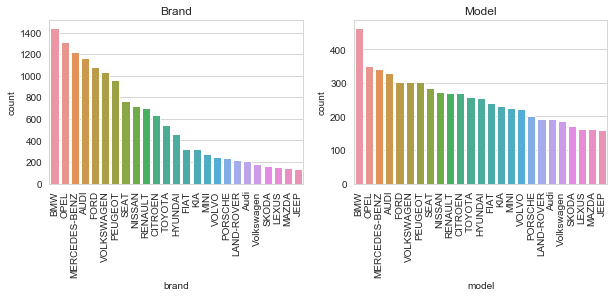

In [59]:
fig, ax =plt.subplots(1, 2, figsize=(10, 3))
i = 0

g = sns.countplot(x='brand', data=df, order=df['brand'].value_counts().iloc[:25].index, ax=ax[0])
g.set_title('Brand')
g2 = sns.countplot(x='model', data=df, order=df['model'].value_counts().iloc[:25].index, ax=ax[1])
g2.set_title('Model')

# 'set_xticklabels' is a shared method between matplotlib and sns
# if called without assignement it will print the labels
_ = g.set_xticklabels(g.get_xticklabels(), rotation=90)
_ =  g2.set_xticklabels(g.get_xticklabels(), rotation=90)

## Top provences

Let's focus on the 5 provences with most appearences, let's see what happens now with the distribution of brands and models uppon the different geographical territories.

Now we have the second surprise; the top 5 provences are: Madrid, Barcelona, Valencia, Málaga and Zaragoza. So strange **we don't find here Sevilla** (4th provence with most inhabitants) and to find Zaragoza (15th in inhabitants).


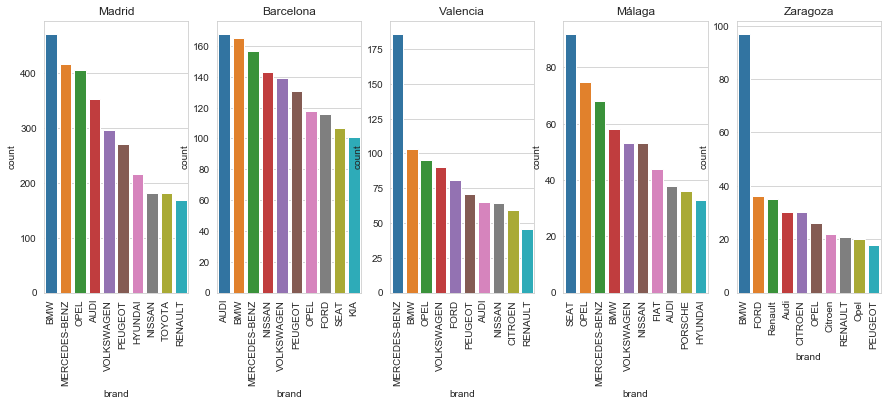

In [60]:
top_provences = df['provence'].value_counts()[:5].index

fig, ax =plt.subplots(1, 5, figsize=(15,5))
i = 0

for provence in top_provences:
    df_temp = df[df["provence"] == provence]
    g = sns.countplot(x='brand', data=df_temp, order=df_temp['brand'].value_counts().iloc[:10].index, ax=ax[i])
    g.set_title(provence)
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    
    i = i + 1

Now we repeat the same for the model, with this view **we can understand why Golf is the king**: it's the most listed car in Madrid and Barcelona and the second in Valencia.

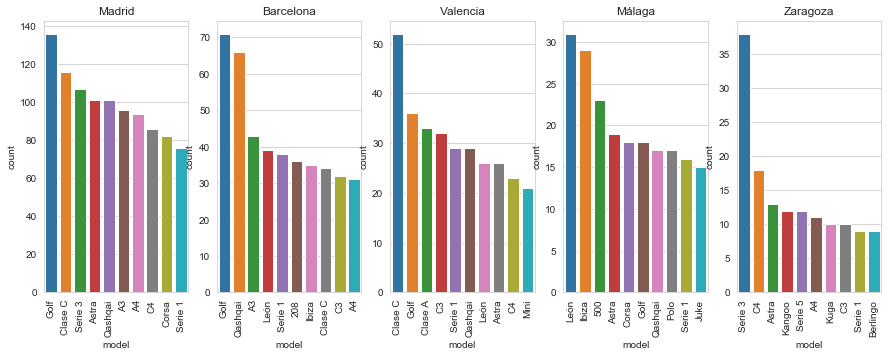

In [61]:
top_provences = df['provence'].value_counts()[:5].index

fig, ax =plt.subplots(1, 5, figsize=(15,5))
i = 0

for provence in top_provences:
    df_temp = df[df["provence"] == provence]
    g = sns.countplot(x='model', data=df_temp, order=df_temp['model'].value_counts().iloc[:10].index, ax=ax[i])
    g.set_title(provence)
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    i = i + 1

Maybe a good point to continue could be to look at the price distribution by provence, because **so many people could think that the richer a region is the more expensive cars are sold**, let's see if they are right.

For a better way of visualization we wil take only top 10 provences, 

In [62]:
top_30 = df['provence'].value_counts().iloc[:10].index.to_list()
df_top_30 = df[df['provence'].isin(top_30)]


df_mean = df_top_30.groupby(['provence']).mean()
df_mean.iloc[:10]

,kilometers,power,price,year
provence,,,,
Alicante,73704.266289,160.980170,21800.161473,2013.702550
Barcelona,47708.544184,151.181695,22231.893147,2015.298918
Las Palmas,67740.990909,153.072727,20378.451515,2015.027273
Madrid,70497.612455,146.641809,18412.273503,2014.579334
Málaga,61070.467120,148.460317,20347.628118,2014.689342
Pontevedra,55281.238606,130.008043,17182.766756,2016.329759
Sevilla,61523.544815,129.089631,16536.562390,2015.952548
Valencia,63235.171935,142.974557,20022.007710,2014.960678
Vizcaya,81323.179361,147.577396,18005.977887,2013.781327


We realised that **Zaragoza has the cheapest cars**, maybe it's due to having the cars with the most kilometers and the oldest. **Pontevedra seems to be a good place to buy a car**, low kilometers and low prices. 

It's time to check the distribution of prices:

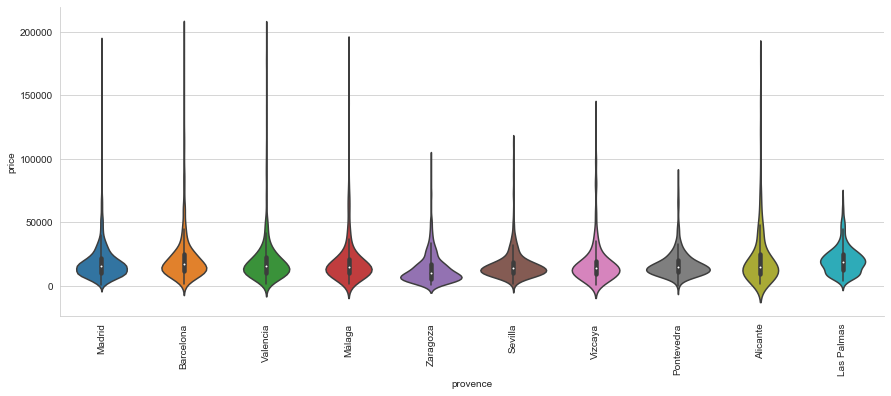

In [63]:
g = sns.catplot(x="provence", y="price", data=df_top_30, order=df_top_30['provence'].value_counts().iloc[:30].index, kind='violin')

g.fig.set_size_inches(15,5)
g.set_xticklabels(rotation=90)

## Price influence
The next step is so clear, **let's see the correlation between each feature and the price**. 

In the future we will make a predictor, applying machine learning and feature engineering in order to guess the price of a car among its features. So it's a good idea to explore each feature to have a first view of the correlations. 

To go ahead with the standard Panda's corr() function it's necessary to encode categorical features, because we want to know how a variable increase or decrease based in other.

So first, **let's check which columns are categorical:**

In [64]:
# We cannot have null when encoding categorical
df.isnull().sum()

fuel          0
kilometers    0
power         0
price         0
provence      0
title         0
year          0
brand         0
model         0
model_info    0
dtype: int64

In [65]:
# Categorical boolean mask
categorical_feature_mask = df.dtypes==object

# filter categorical columns using mask and turn it into a list
categorical_cols = df.columns[categorical_feature_mask].tolist()

# import labelencoder
from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
le = LabelEncoder()

# apply le on categorical feature columns
df[categorical_cols] = df[categorical_cols].apply(lambda col: le.fit_transform(col))

In this moment we have our panda's dataframe with encoded columns, it's time to go deep inside and where the price comes from. **A good idea could be to start with a Seaborn Pairplot, but as we have too much features we will use a correlation matrix before.**

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <a list of 10 Text yticklabel objects>)

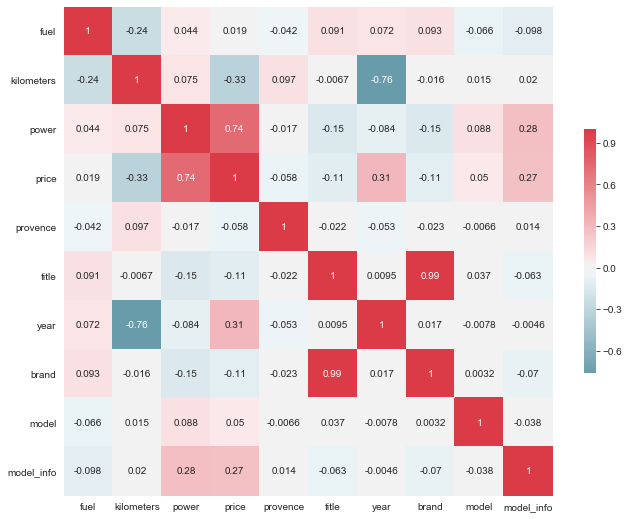

In [66]:
# Compute the correlation matrix
corr = df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, annot=True, center=0,
            square=True, cbar_kws={"shrink": .5})

plt.yticks(rotation=0)

As logical, **the price is highly influenced by the power (incredible 74%), the year and the model (model info concretely).** Some other logical things we can see here: year and kms are negative correlated, normally old cars have more kms than newer ones. Also price and kms; **normally cars with more kms are cheapers.**

Maybe it could be interesting to take a look at how those factors change with the price. **Let's see the distributions of the top correlated with the price.**

In [67]:
# Correlation only with target feature
cor_target = abs(corr['price'])

# High related features
relevant_features = cor_target[cor_target>0.25]
relevant_features

kilometers    0.328400
power         0.736389
price         1.000000
year          0.311814
model_info    0.266843
Name: price, dtype: float64

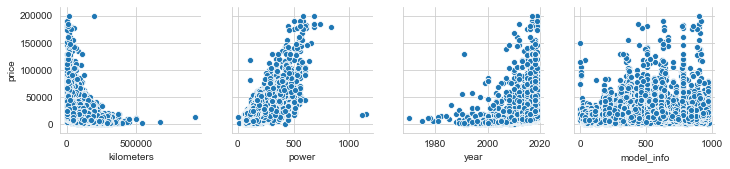

In [68]:
df_relevant_features = df[relevant_features.index]
features_no_price = relevant_features.index.tolist()
features_no_price.remove('price')

sns.pairplot(data=df_relevant_features, y_vars=['price'], x_vars=features_no_price)

**Good! We find some distributed relationships!!** As you can see it's clear that more powerful cars are more expensive, older cars are cheaper and more kms means lower price. **We can guess that maybe less kms + more power + newer year means more expensive.**

In the next notebook **we will try to predict the value of a car based on those features** and comparing different model approaches and feature enginering for improving performance.